In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, ELU, Sequential, Conv1d, MaxPool1d, Module, BatchNorm1d, AvgPool1d, Dropout
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, AvgPool2d
import torch.nn.functional as F
import torch.optim as optim

import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *
from CNNRES_Monitor_Dilated3_hrrr import CNNRES_Monitor_Dilated3_hrrr

In [2]:
# Where the tensor is saved
tensor_dir = '/TENSOR_DIR'

# Make sure to run on GPU

In [2]:
# For reproducibility
torch.manual_seed(1234)

# Detect if we have a GPU available
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")
else:
    print("Using CPU")

True
Using GPU


In [3]:
class generate_args:
    def __init__(self):
        self.lr = 5e-5
        self.bsz = 32
        self.num_epoch = 200
        self.early_stop = 50
        self.only_evaluate = False
        self.dropout = 0.0
        self.decay_rate = 0.9
        self.weight_decay = 0.0005
        self.rr_weight = 1.25
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_gpu = torch.cuda.device_count()
        
args = generate_args()

# Load data

In [4]:
df = pd.read_csv('./2_use_df.csv')

print(f'Num clips: {len(df)}')

Num clips: 2732


In [5]:
hr_rr = torch.tensor(df[['hr','rr']].values)
doppler = torch.load(tensor_dir+'/doppler_use.pt')

In [7]:
class RadarDataset_NCC(Dataset):
    def __init__(self, iq_data, hr_label):
        super().__init__()
        self.iq_data, self.hr_label = iq_data, hr_label
        
    def __len__(self):
        return len(self.hr_label)
    
    def __getitem__(self, idx):
        iq = self.iq_data[idx].float().to(device)
        hr = self.hr_label[idx].float().to(device)
        
        iq_conv = F.conv1d(iq.view(1,2,iq.shape[1]),w_filter,padding=w_filter.shape[2]//2).squeeze()
        iq = torch.cat([iq,iq_conv])
        
        return iq,hr,idx//10

In [8]:
class Trainer(object):
    def __init__(self, args, in_channel=2, RadarDataset=RadarDataset_NCC):
        #self.total_num = len(bi_data)
        self.args = args
        self.in_channel = in_channel
        self.RadarDataset = RadarDataset
        self.device = device
        self.freq = []
        for i in range(int(5/0.2)+1):
            self.freq.append(i*0.2)
        hr_15, dp_15 = slice_data(hr_rr,doppler)
        self.iq_data = dp_15
        self.hr_label = hr_15

        print()
        print('tot number of data ', len(self.iq_data))
        print('length per sample ', self.iq_data.shape)
        
        self.dataset = self.RadarDataset('all', self.iq_data, self.hr_label)

        n = len(hr_rr)
        split = [0.8, 0.1, 0.1]

        split_n = lambda x,n: [int(x[0]*n), n-int(x[2]*n)]
        split = split_n(split,n)
        print('Train, validation, test split: ', split)
        generator1 = torch.Generator().manual_seed(42)
        idx = torch.randperm(len(hr_rr),generator=generator1)
        self.train_set = self.RadarDataset(*slice_data(hr_rr[idx[:split[0]]],doppler[idx[:split[0]]]))
        self.val_set = self.RadarDataset(*slice_data(hr_rr[idx[split[0]:split[1]]],doppler[idx[split[0]:split[1]]]))
        self.test_set = self.RadarDataset(*slice_data(hr_rr[idx[split[1]:]],doppler[idx[split[1]:]]))
        
        self.train_loader = DataLoader(self.train_set, batch_size=self.args.bsz, shuffle=True, drop_last=True)
        self.val_loader = DataLoader(self.val_set, batch_size=self.args.bsz)
        self.test_loader = DataLoader(self.test_set, batch_size=self.args.bsz)
        
        self.model = CNNRES_Monitor_Dilated3_hrrr(args, self.device, in_channels=self.in_channel)
        self.model = self.model.to(self.device)
        self.model = self.model.float()
        self.loss = 'MSE'
    
        
    def calc_loss(self, pred, target):
        if self.loss == 'MSE':
            return nn.functional.mse_loss(pred, target, reduction='sum')
        elif self.loss == 'L1Loss':
            return nn.functional.l1_loss(pred, target, reduction='sum')
        elif self.loss == 'BCE':
            return nn.BCEWithLogitsLoss(reduction='sum')(pred, target)
        
    def evaluate(self, evaluate_type):
        self.model.eval()
        if evaluate_type == 'train':
            loader = self.train_loader
        if evaluate_type == 'test':
            loader = self.test_loader
        if evaluate_type == 'val':
            loader = self.val_loader
        
        with torch.no_grad():
            self.model.eval()
            loss = 0
            hits = 0
            for batch_idx, (iq, hr,_) in enumerate(loader):
                iq = iq.to(self.device)
                hr = hr.to(self.device)
                pred = self.model(iq)
                target = hr.view(hr.size()[0], -1)
                loss += self.calc_loss(pred.float(), target.float()).item()
                hits += (torch.round(pred) == torch.round(target)).sum().item()
            
            hits /= len(loader.dataset)
            loss /= len(loader.dataset)
            
            return hits, loss
            
    def train(self, l_rate, model_name):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=l_rate)
        my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=self.args.decay_rate)
        train_loss = []
        valid_loss = []
        num_train = len(self.train_loader.dataset)
        min_loss = float('inf')
        early_stop = 0
        for epoch in range(self.args.num_epoch):
            print("Epoch", epoch)
            tot_loss = 0
            val_hits, val_loss = self.evaluate('val')
            print('Epoch: {}, Validation Loss: {}, Validation Accuracy: {}'.format(epoch, val_loss, val_hits))
            valid_loss.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                best_model_wgts = copy.deepcopy(self.model.state_dict())
                early_stop = 0
                save_path = os.path.join(f"./model/{model_name}.pt")
                torch.save(self.model.state_dict(), save_path)
                print(f"Model saved at {save_path}, epoch {epoch}")
            else:
                early_stop += 1
            if early_stop > self.args.early_stop:
                break
            
            for batch_idx, (iq, hr,_) in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
                self.model.train()
                optimizer.zero_grad()
                iq = iq.to(self.device)
                hr = hr.to(self.device)
                pred = self.model(iq)
                target = hr.view(self.args.bsz, -1)
                loss = self.calc_loss(pred.float(), target.float())
                loss = loss.float()
                tot_loss += loss.item()
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                    
            print('Epoch: {}, Training Loss: {}'.format(epoch, tot_loss/num_train))
            train_loss.append(tot_loss/num_train)
            my_lr_scheduler.step()
        
        self.model.load_state_dict(best_model_wgts)
        return train_loss, valid_loss, min_loss, epoch

# With amplification

In [9]:
def single_hr_cycle(target_hr, 
                    dt=1/1000, 
                    omega1=30, 
                    omega2=40, 
                    length=299):
    T = 60 / target_hr
    t = np.linspace(0, T, int(T/dt), endpoint=False)
    omega1 /= T
    omega2 /= T
    gamma = 1
    b = T/2
    c = T*1e-3
    pulse = np.exp(-(t-b)**2./c)
    g_shape = np.cos(omega1*t + gamma*np.sin(omega2*t));
    w = g_shape * pulse
    # normalize
    w = w/w.sum();
    if abs(min(w)) > abs(max(w)):
        w = -w
    n = len(w)
    if n < length:
        w1 = np.zeros(length)
        start = (length - n) // 2
        w1[start:start+n] = w
    else:
        start = (n-length)//2
        w1 = w[start:start+length]
    return torch.tensor(w1)

In [10]:
length = 199

w_40 = single_hr_cycle(40,length=length)
w_60 = single_hr_cycle(60,length=length)
w_80 = single_hr_cycle(80,length=length)
w_100 = single_hr_cycle(100,length=length)

w_filter = torch.zeros(8,2,length)
w_filter[:4,0,:] = torch.stack([w_40,w_60,w_80,w_100])
w_filter[4:,1,:] = torch.stack([w_40,w_60,w_80,w_100])
w_filter = w_filter.float().to(device)

In [11]:
def w_filter_conv(iq):
    iq_conv = F.conv1d(iq.view(1,2,iq.shape[1]),w_filter,padding=w_filter.shape[2]//2).squeeze()
    iq = torch.cat([iq,iq_conv])
    return iq

# Model

In [12]:
args = generate_args()
torch.set_default_dtype(torch.float64)

trainer = Trainer(args, in_channel=10, RadarDataset=RadarDataset_NCC)

trainer.model.load_state_dict(torch.load('./model/resnet_hrrr_best.pt'))
trainer.model.to(trainer.device)

now = datetime.now()
now = now.strftime("%m%d%H%M%S")
print('Time: ',now)


tot number of data  27320
length per sample  torch.Size([27320, 2, 15000])
Train, validation, test split:  [21856, 2732, 2732]
Time:  0811001000


In [ ]:
args.lr = 5e-5
trainer.loss = 'L1Loss'

training_loss, val_loss, min_loss, num_epoch = trainer.train(args.lr, 'resnet_hrrr_'+now)

In [13]:
trainer.loss = 'L1Loss'
hits, loss = trainer.evaluate('train')
print('train hits ', hits)
print('train loss ', loss)

/nobackup/users/rduan/anaconda3/envs/torch3/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /data/florin/opence-conda-bld/pytorch-base_1633186805378/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


train hits  0.6179538799414348
train loss  2.4361118547738383


In [14]:
trainer.loss = 'L1Loss'
hits, loss = trainer.evaluate('val')
print('val hits ', hits)
print('val loss ', loss)

val hits  0.465592972181552
val loss  3.741113457463322


In [15]:
trainer.loss = 'L1Loss'
hits, loss = trainer.evaluate('test')
print('test hits ', hits)
print('test loss ', loss)

test hits  0.4835285505124451
test loss  3.7330429752958643


In [16]:
actions = df['action_clean'].unique()
actions_count = {action: 0 for action in actions}
actions_hr = {action: 0 for action in actions}
actions_rr = {action: 0 for action in actions}

for i in tqdm(range(len(trainer.test_set))):

    target = trainer.test_set[i][1]

    with torch.no_grad():
        datapoint = trainer.test_set[i][0].unsqueeze(0)
        idx = trainer.test_set[i][2]
        action = df.loc[idx,'action_clean']
        pred = trainer.model(datapoint)
        actions_count[action] += 1
        actions_hr[action] += np.abs(target[0].item() - pred[0,0].item())
        actions_rr[action] += np.abs(target[1].item() - pred[0,1].item())

100%|██████████| 2732/2732 [00:26<00:00, 104.81it/s]


In [17]:
print(f'RR MAE: {sum(actions_rr.values()) / 2732}')
print(f'HR MAE: {sum(actions_hr.values()) / 2732}')

RR MAE: 1.336182701563678
HR MAE: 2.396861403787817


In [18]:
actions_hr_each = {}
actions_rr_each = {}

for action in actions:
    actions_hr_each[action] = actions_hr[action] / actions_count[action]
    actions_rr_each[action] = actions_rr[action] / actions_count[action]

actions_hr_each = [actions_hr_each[action] for action in actions]
actions_rr_each = [actions_rr_each[action] for action in actions]

Text(0.5, 1.0, 'MAE of respiration rate by actions')

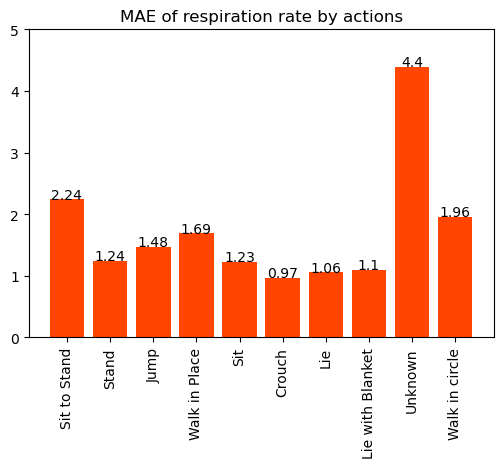

In [19]:
fig,ax = plt.subplots(figsize=(6,4))

ax.bar(actions, actions_rr_each, color='orangered')
ax.set_ylim(0,5)
plt.xticks(rotation=90)
for i in range(len(actions_rr_each)):
    ax.text(i, actions_rr_each[i]+0.01, np.round(actions_rr_each[i],2), ha = 'center')
ax.set_title('MAE of respiration rate by actions')

## R^2

In [20]:
baseline = torch.zeros(2)

for i in tqdm(range(len(trainer.train_set))):
    baseline += trainer.train_set[i][1].cpu() / len(trainer.train_set)

100%|██████████| 21856/21856 [00:06<00:00, 3404.97it/s]


In [21]:
baseline

tensor([70.0568, 15.2972])

In [22]:
def calc_r2(dataset, baseline):
    rss = torch.zeros(2)
    tss = torch.zeros(2)
    for i in tqdm(range(len(dataset))):
        target = dataset[i][1].cpu()

        with torch.no_grad():
            datapoint = dataset[i][0].unsqueeze(0)
            pred = trainer.model(datapoint)[0].cpu()
            rss += (target - pred)**2
            tss += (target - baseline) **2
    return 1 - rss/tss

In [23]:
calc_r2(trainer.train_set, baseline)

100%|██████████| 21856/21856 [03:25<00:00, 106.51it/s]


tensor([0.9689, 0.8898])

In [24]:
calc_r2(trainer.val_set, baseline)

100%|██████████| 2732/2732 [00:25<00:00, 106.51it/s]


tensor([0.9030, 0.7876])

In [25]:
calc_r2(trainer.test_set, baseline)

100%|██████████| 2732/2732 [00:25<00:00, 106.65it/s]


tensor([0.9080, 0.7787])

In [26]:
def calc_mae(dataset):
    rss = torch.zeros(2)
    for i in tqdm(range(len(dataset))):
        target = dataset[i][1].cpu()

        with torch.no_grad():
            datapoint = dataset[i][0].unsqueeze(0)
            pred = trainer.model(datapoint)[0].cpu()
            rss += torch.abs(target - pred)
    return rss / len(dataset)

In [27]:
print(calc_mae(trainer.train_set))
print(calc_mae(trainer.val_set))
print(calc_mae(trainer.test_set))

100%|██████████| 21856/21856 [03:24<00:00, 107.04it/s]


tensor([1.4814, 0.9547])


100%|██████████| 2732/2732 [00:25<00:00, 106.47it/s]


tensor([2.4239, 1.3172])


100%|██████████| 2732/2732 [00:25<00:00, 106.86it/s]

tensor([2.3969, 1.3362])


In [28]:
s = 0.5
dp = trainer.train_set[200][0].cpu()[:,:int(1000*s)]

Text(0.5, 0, 'Seconds')

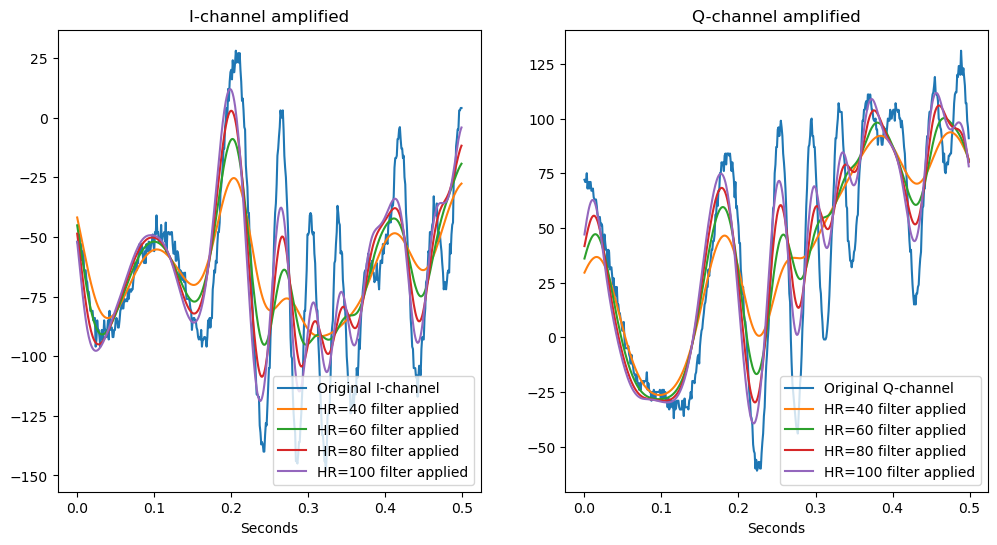

In [29]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
t = np.arange(0,s,1/1000)

ax[0].plot(t,dp[0],label='Original I-channel')
ax[1].plot(t,dp[1],label='Original Q-channel')
ax[0].plot(t,dp[2],label='HR=40 filter applied')
ax[0].plot(t,dp[3],label='HR=60 filter applied')
ax[0].plot(t,dp[4],label='HR=80 filter applied')
ax[0].plot(t,dp[5],label='HR=100 filter applied')
ax[1].plot(t,dp[6],label='HR=40 filter applied')
ax[1].plot(t,dp[7],label='HR=60 filter applied')
ax[1].plot(t,dp[8],label='HR=80 filter applied')
ax[1].plot(t,dp[9],label='HR=100 filter applied')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[0].set_title('I-channel amplified')
ax[1].set_title('Q-channel amplified')
ax[0].set_xlabel('Seconds')
ax[1].set_xlabel('Seconds')